# Introduction

This is a simplified version of the code used to generate some of the results of the paper

<br>

"Approximation of Nearly-Periodic Symplectic Maps via Structure-Preserving Neural Networks"

Valentin Duruisseaux, Joshua W. Burby, and Qi Tang.

*Scientific Reports, Collection on "Physics-informed Machine Learning and its real-world applications"*, 2023.

https://arxiv.org/abs/2210.05087

<br>





In this notebook, we use the symplectic gyroceptron architecture to learn a surrogate map for the nearly-periodic symplectic flow map associated to a nearly-periodic Hamiltonian system composed of two nonlinearly coupled oscillators, where one of them oscillates significantly faster than the other:

$$ \begin{cases} \dot{q}_1 = p_1 \qquad & \dot{p}_1 = -q_1 - \varepsilon \partial_{q_1} U(q_1,q_2) \\ \dot{q}_2 = \varepsilon p_2 \qquad & \dot{p}_2 = -\varepsilon q_2 - \varepsilon \partial_{q_2} U(q_1,q_2)
\end{cases} $$

<br>

These equations of motion are the Hamilton's equations associated to the Hamiltonian
$$ H_\varepsilon (q_1,q_2,p_1,p_2) = \frac{1}{2} (q_1^2 + p_1^2 ) + \frac{1}{2} \varepsilon (q_2^2 + p_2^2 )  + \varepsilon U(q_1,q_2)    $$

<br>


# Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
tf.keras.backend.set_floatx('float32')


# Parameters


## Problem Parameters

In [2]:
# Near-periodicity parameter
epsilon = 0.01

# Step size
rk4_step = 0.0005

# Number of steps per iteration
n_steps_per_rk4_eval = 100

## Symplectic Gyroceptron Parameters

In [3]:
# Number and shape of layers in Henon Network psi
HenonLayersShape = []
for i in range(10):
    HenonLayersShape.append(8)

# Number and shape of layers in Near-Identity Henon Network I_epsilon
NIHenonLayersShape = []
for i in range(8):
    NIHenonLayersShape.append(6)

## Training Parameters

In [4]:
# Loss Function (Weigthed MSE)
def custom_loss(y_true, y_pred):
    diff = (y_true - y_pred)**2
    Oscillator1_Loss =  epsilon * (tf.math.reduce_sum(diff[:,0]) + tf.math.reduce_sum(diff[:,2]))
    Oscillator2_Loss = tf.math.reduce_sum(diff[:,1]) + tf.math.reduce_sum(diff[:,3])
    return  Oscillator1_Loss + Oscillator2_Loss


# Optimizer
Optim = keras.optimizers.Adam(learning_rate = 0.1, clipnorm = 0.1) 

# Either train from scratch, or upload weights from previous training
train = True

if train:
    
    initial_epoch = 0 
    
    # Number of data points to learn from
        # In general Window
    n_general_points = 20000
        # In small window near orbits on the right
    n_points_small_right_orbits = 20000
        # In small window near orbits on the left
    n_points_small_left_orbits = 20000
    
    number_data_points = n_general_points + n_points_small_right_orbits + n_points_small_left_orbits

    # Batch Size
    my_batch_size = 512

    # Number of epochs
    n_epochs = 5600

    # Save every how many epochs ? 
    n_epochs_before_save = n_epochs
    
    # Define scheduler
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=8, mode='min')
    
else:
    # Location of saved weights
    SavedWeights = "./TrainingWeights/my_saved_weights.ckpt"

## Prediction Parameters

In [5]:
# Number of iterations computed in the final predictions   
n_pred_steps = 40000      

# Number of trajectories to evolve in the final predictions
n_ics = 7    

# Initial conditions
q1_ic = 1.5*np.ones((n_ics,1))
p1_ic = np.zeros((n_ics,1))
q2_ic = np.array([0.0, 0.15, 0.3, 0.4, 1.0, 1.45, 1.55]).reshape([n_ics,1])
p2_ic = np.zeros((n_ics,1))

z_ic = np.hstack([q1_ic,q2_ic,p1_ic,p2_ic]) 

# Potential and Vector Field

Here the potential is taken to be

$$ U(q_1,q_2) = q_1 q_2 \sin{(2q_1+2q_2)}$$

and the equations of motion are

\begin{equation} \begin{cases}
		\dot{q}_1 = p_1 \qquad & \dot{p}_1 = -q_1 - \varepsilon \partial_{q_1} U(q_1,q_2) \\ \dot{q}_2 = \varepsilon p_2 \qquad & \dot{p}_2 = -\varepsilon q_2 - \varepsilon \partial_{q_2} U(q_1,q_2)
\end{cases} \end{equation}

<br>

In [6]:
# Potential U and its partial derivatives

def Potential(q1,q2): 
    return  q1*q2*tf.math.sin(2*q1+2*q2)

def dUdq1(q1,q2):
    return q2*tf.math.sin(2*q1+2*q2) + 2*tf.math.cos(2*q1+2*q2)*q1*q2

def dUdq2(q1,q2):
    return q1*tf.math.sin(2*q1+2*q2) + 2*tf.math.cos(2*q1+2*q2)*q1*q2


# Takes set of z=(q1,p1,q2,p2) points, and returns array of corresponding values of zdot
@tf.function
def zdot(z,epsilon):
    n = z.shape[0]
    q1 = z[:,0] 
    q2 = z[:,1]
    p1 = z[:,2]
    p2 = z[:,3]
    
    q1dot = tf.reshape(p1, [n,1])  
    q2dot = tf.reshape(epsilon*p2, [n,1]) 
    p1dot = tf.reshape(-q1-epsilon*dUdq1(q1,q2), [n,1])
    p2dot = tf.reshape(- epsilon*q2 - epsilon*dUdq2(q1,q2) , [n,1]) 
  
    return tf.concat([q1dot, q2dot, p1dot, p2dot], 1)

<br>

To simulate the reference trajectories and create the dataset, we use the classical Runge-Kutta 4 method with very small time-steps

In [7]:
# RK4 integration for n_steps
def rk4(z0,time_step,epsilon,n_steps):
    h = time_step
    z = z0
    for i in range(n_steps):
        k1 = zdot(z,epsilon)
        k2 = zdot(z + 0.5*h*k1,epsilon)
        k3 = zdot(z + 0.5*h*k2,epsilon)
        k4 = zdot(z + h * k3,epsilon)
        z = z + (1.0/6.0) * h * (k1 + 2*k2 + 2*k3 + k4) 
    return z

<br>

# Generate Data and Labels for Training


In [8]:
if train:
    
    # Points in full [-0.9,1.6]x[-1.1,1.1] window for oscillator 2
    q1_data1 = -1.6 + 3.2*tf.random.uniform((n_general_points,1), dtype=tf.dtypes.float32)
    q2_data1 = -0.9 + 2.5*tf.random.uniform((n_general_points,1), dtype=tf.dtypes.float32)
    p1_data1 = -1.6 + 3.2*tf.random.uniform((n_general_points,1), dtype=tf.dtypes.float32)
    p2_data1 = -1.1 + 2.2*tf.random.uniform((n_general_points,1), dtype=tf.dtypes.float32)

    # More points for smaller right orbits in [0.6,1.5]x[-0.5,0.5] for oscillator 2
    q1_data2 = -1.6 + 3.2*tf.random.uniform((n_points_small_right_orbits,1), dtype=tf.dtypes.float32)
    q2_data2 =  0.6 + 0.9*tf.random.uniform((n_points_small_right_orbits,1), dtype=tf.dtypes.float32)
    p1_data2 = -1.6 + 3.2*tf.random.uniform((n_points_small_right_orbits,1), dtype=tf.dtypes.float32)
    p2_data2 = -0.5 + 1.0*tf.random.uniform((n_points_small_right_orbits,1), dtype=tf.dtypes.float32)

    # More points for smaller left orbits in [-0.75,0.75]x[-0.75,0.75] for oscillator 2
    q1_data3 = -1.6 + 3.2*tf.random.uniform((n_points_small_left_orbits,1), dtype=tf.dtypes.float32)
    p1_data3 = -1.6 + 3.2*tf.random.uniform((n_points_small_left_orbits,1), dtype=tf.dtypes.float32)
    q2_data3 = -0.8 + 1.6*tf.random.uniform((n_points_small_left_orbits,1), dtype=tf.dtypes.float32)
    p2_data3 = -0.8 + 1.6*tf.random.uniform((n_points_small_left_orbits,1), dtype=tf.dtypes.float32)

    # Concatenate all the data
    data = tf.concat([tf.concat([q1_data1, q1_data2, q1_data3], 0), 
                      tf.concat([q2_data1, q2_data2, q2_data3], 0), 
                      tf.concat([p1_data1, p1_data2, p1_data3], 0), 
                      tf.concat([p2_data1, p2_data2, p2_data3], 0)], 1)

    # Evolve the data using RK4 to generate the labels
    labels = rk4(data,rk4_step,epsilon, n_steps_per_rk4_eval)

<br>

# Neural Network Architecture

## Henon map, Henon layer, and HenonNet 

We first define the <b>near-identity Henon map</b>
$$	H_\varepsilon[V,\eta]\begin{pmatrix} x\\y \end{pmatrix} = \begin{pmatrix} y + \eta\\ -x + \varepsilon \nabla V(y) \end{pmatrix}$$

which reduces to the regular Henon Map when $\varepsilon = 1$.

<br>

In our network, we will take

$$V(y) = W_{out}^\top \tanh{(W_{in}^\top y + b_{in})}$$

for some weight matrices $W_{in}, W_{out}$ and bias $b_{in}$

In [9]:
def HenonMap(X,Y,W_in,W_out,b_in,eta,epsilon=1):
    with tf.GradientTape() as tape:
        tape.watch(Y)
        V = tf.linalg.matmul(tf.math.tanh(tf.linalg.matmul(Y, W_in) + b_in),W_out)
    X_out= Y + eta 
    Y_out= -X + epsilon*tape.gradient(V,Y) 
    return X_out, Y_out

<br>

We then define a <b>Henon layer</b> as the composition of 4 copies of a Henon map

$$L_\varepsilon[V,\eta] = H_\varepsilon[V,\eta]^4$$



In [10]:
class HenonLayer(layers.Layer): 
    def __init__(self,ni,epsilon =1):
        super(HenonLayer, self).__init__()
        self.dim = 2   # half of the dimension of the full space
        self.epsilon = epsilon
        
        # Initialize weights
        init = tf.initializers.GlorotNormal()   
        init_zero = tf.zeros_initializer()
        W_in_init = init(shape=[self.dim,ni], dtype = tf.float32)
        W_out_init = init(shape=[ni,1], dtype = tf.float32)
        b_in_init = init(shape=[1,ni], dtype = tf.float32)
        eta_init = init(shape=[1,self.dim], dtype = tf.float32)
        
        self.W_in = tf.Variable(W_in_init, dtype = tf.float32)
        self.W_out = tf.Variable(W_out_init, dtype = tf.float32)
        self.b_in = tf.Variable(b_in_init, dtype = tf.float32)
        self.eta = tf.Variable(eta_init, dtype = tf.float32)
    
    def call(self,z):
        xnext,ynext=HenonMap(z[:,0:self.dim],z[:,self.dim:],self.W_in,self.W_out,self.b_in,self.eta,self.epsilon)
        xnext,ynext=HenonMap(xnext,ynext,self.W_in,self.W_out,self.b_in,self.eta,self.epsilon) 
        xnext,ynext=HenonMap(xnext,ynext,self.W_in,self.W_out,self.b_in,self.eta,self.epsilon) 
        xnext,ynext=HenonMap(xnext,ynext,self.W_in,self.W_out,self.b_in,self.eta,self.epsilon) 
        return tf.concat([xnext,ynext], axis =1)

## Inverse Henon Map and Henon Layer

Next we define the inverse of the Henon map 
$$	H_\varepsilon[V,\eta]\begin{pmatrix} x\\y \end{pmatrix} = \begin{pmatrix} y + \eta\\ -x + \varepsilon \nabla V(y) \end{pmatrix}$$
which is given by
$$H^{-1}_\varepsilon[V,\eta]\begin{pmatrix} x\\y \end{pmatrix} = \begin{pmatrix} \varepsilon \nabla V(x-\eta) - y \\ x - \eta   \end{pmatrix} $$

<br>

The <b>inverse Henon layer</b> is then the composition of 4 copies of the inverse Henon map


In [11]:
def InverseHenonMap(X,Y,W_in,W_out,b_in,eta,epsilon=1.):
    Y_out = X - eta
    with tf.GradientTape() as tape:
        tape.watch(Y_out)
        V = tf.linalg.matmul(tf.math.tanh(tf.linalg.matmul(Y_out, W_in) + b_in),W_out)
    X_out=  epsilon*tape.gradient(V,Y_out) - Y
    return X_out, Y_out



def InverseHenonLayer(z, original_layer): 
    # The original Henon layer is an input
    
    # Get parameter values and weights of the original Henon layer
    epsilon = original_layer.epsilon
    dim = original_layer.dim
    W_in = original_layer.W_in
    W_out = original_layer.W_out
    b_in = original_layer.b_in
    eta = original_layer.eta

    # Evaluate the inverse Henon layer Map
    xnext,ynext=InverseHenonMap(z[:,0:dim],z[:,dim:],W_in,W_out,b_in,eta,epsilon)
    xnext,ynext=InverseHenonMap(xnext,ynext,W_in,W_out,b_in,eta,epsilon) 
    xnext,ynext=InverseHenonMap(xnext,ynext,W_in,W_out,b_in,eta,epsilon) 
    xnext,ynext=InverseHenonMap(xnext,ynext,W_in,W_out,b_in,eta,epsilon) 
    return tf.concat([xnext,ynext], axis =1)


## Circle Action Layer



The circle action is 
$$ \Phi_{\theta}(q_1,q_2,p_1,p_2) =\begin{pmatrix} \cos\theta & 0 & \sin\theta & 0\\ 0 & 1 & 0 & 0\\  -\sin\theta  & 0 & \cos\theta & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} q_1 \\ q_2 \\ p_1 \\ p_2 \end{pmatrix} $$

<br>

This corresponds to clockwise circular rotation of the the components $(q_1,p_1)$ in phase space



In [12]:
class CircleActionLayer(layers.Layer):
    def __init__(self):
        super(CircleActionLayer, self).__init__()
        init = tf.initializers.GlorotNormal()   
        theta0_init = init(shape=[1,1], dtype = tf.float32)
        self.theta0 = tf.Variable(theta0_init, dtype = tf.float32)
    
    def call(self,z):
        theta0 = self.theta0
        q1 = z[:,0:1]
        q2 = z[:,1:2]
        p1 = z[:,2:3]
        p2 = z[:,3:]
        # Last columns for p2 values
        r_out = p2
        # Add 3rd column for new values of p1
        r_out = tf.concat([tf.cos(theta0)*p1-tf.sin(theta0)*q1, r_out], 1)
        # Add 2nd column for new values of q2
        r_out = tf.concat([q2, r_out], 1)
        # Add 1st column for new values of q1
        r_out = tf.concat([tf.cos(theta0)*q1+tf.sin(theta0)*p1, r_out], 1)
        return r_out

##  Symplectic Gyroceptron

The <b>symplectic gyroceptron</b> is defined as the composition
$$ I_\varepsilon \ \circ \  \psi \ \circ \  \Phi_{\theta} \ \circ \  \psi^{-1}$$

where $I_\varepsilon$ is a neural network capable of learning near-identity symplectic maps, $\psi$ is a neural network capable of learning symplectic maps, and $\Phi_{\theta}$ is a circle action. 

<br>

Here we choose $I_\varepsilon$ to be a near-identity Henon network and $\psi$ to be a Henon network.

These networks are defined as compositions of near-identity Henon layers and Henon layers

In [13]:
class SymplecticGyroceptron(Model):

    def __init__(self,NIHenon_unit_list,Henon_unit_list,eps):
        super(SymplecticGyroceptron, self).__init__()
        self.N_Henon = len(Henon_unit_list)
        self.N_NI_Henon = len(NIHenon_unit_list)
        self.psi_layers = []
        self.NI_layers = []
        self.hlayers = []
        self.epsilon = eps
       
        # Create Circle Action
        hl = CircleActionLayer()
        self.hlayers.append(hl)
        
        # HenonNet psi
        for i in range(self.N_Henon):
            # Get the number of neurons in i-th Henon layer
            ni = Henon_unit_list[i]
            # Create i-th Henon layer
            hl = HenonLayer(ni,epsilon=1.0) 
            # Add i-th Henon layer 
            self.psi_layers.append(hl)
            self.hlayers.append(hl)
        
        # Near_Identity_Henon_Net
        for i in range(self.N_NI_Henon):
            # Get the number of neurons in i-th Henon layer
            ni = NIHenon_unit_list[i]
            # Create and add the i-th Henon layer
            hl = HenonLayer(ni,epsilon=self.epsilon) 
            self.hlayers.append(hl)
            self.NI_layers.append(hl)

    @tf.function
    def call(self, r): 
        # Evaluate the HenonNet by passing the input r through each layer
        r_out = r
        
        # First pass through psi inverse
        NumberPsiLayers = self.psi_layers.__len__()
        for i in range(NumberPsiLayers):
            r_out = InverseHenonLayer(r_out, self.psi_layers[NumberPsiLayers-i-1])
        
        # Then pass through the other layers
        NumberLayers = self.hlayers.__len__()
        for i in range(NumberLayers):
            r_out = self.hlayers[i](r_out)
        return r_out

<br>

# Build and Train Model

## Define Model

In [14]:
# Build model
SG = SymplecticGyroceptron(NIHenonLayersShape,HenonLayersShape, epsilon)


# Upload weights
if train == False:
    SG.load_weights(SavedWeights)

# Compile model
SG.compile(optimizer = Optim, loss = custom_loss)


# Evaluate Model Briefly to make sure it works and print its summary
SG.evaluate(tf.random.normal([10,4]),tf.random.normal([10,4]), batch_size=5)
SG.summary()

2/2 [==============================] - 2s 6ms/step - loss: 15.8110
Model: "symplectic_gyroceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
henon_layer (HenonLayer)     multiple                  34        
_________________________________________________________________
henon_layer_1 (HenonLayer)   multiple                  34        
_________________________________________________________________
henon_layer_2 (HenonLayer)   multiple                  34        
_________________________________________________________________
henon_layer_3 (HenonLayer)   multiple                  34        
_________________________________________________________________
henon_layer_4 (HenonLayer)   multiple                  34        
_________________________________________________________________
henon_layer_5 (HenonLayer)   multiple                  34        
___________________________________________

## Train Model

Epoch 1/5600
118/118 [==============================] - 12s 24ms/step - loss: 0.5554
Epoch 2/5600
118/118 [==============================] - 3s 22ms/step - loss: 1.1546e-04
Epoch 3/5600
118/118 [==============================] - 3s 22ms/step - loss: 0.0026
Epoch 4/5600
118/118 [==============================] - 3s 22ms/step - loss: 1.1331e-04
Epoch 5/5600
118/118 [==============================] - 3s 22ms/step - loss: 8.3917e-05
Epoch 6/5600
118/118 [==============================] - 3s 22ms/step - loss: 1.2605e-04
Epoch 7/5600
118/118 [==============================] - 3s 22ms/step - loss: 0.0045
Epoch 8/5600
118/118 [==============================] - 3s 22ms/step - loss: 9.2063e-04
Epoch 9/5600
118/118 [==============================] - 3s 22ms/step - loss: 1.9258e-04
Epoch 10/5600
118/118 [==============================] - 3s 22ms/step - loss: 6.9199e-05
Epoch 11/5600
118/118 [==============================] - 3s 22ms/step - loss: 6.3136e-05
Epoch 12/5600
118/118 [==================

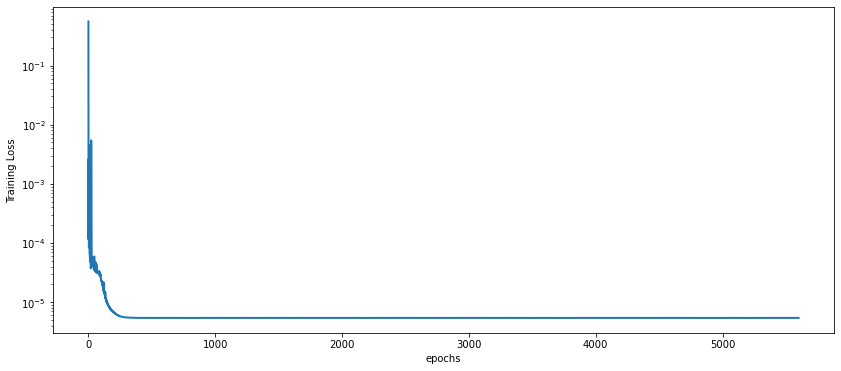

In [15]:
if train:

    # Callback to Save Weights
    checkpoint_path = "./TrainingWeights/epoch_{epoch:05d}.ckpt"
    saving_frequency = n_epochs_before_save*(int(number_data_points/my_batch_size)+1)
    callback_SaveWeights = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=0, 
                                                              save_weights_only=True, save_freq=saving_frequency)
    
    # Training
    h = SG.fit(data, labels, batch_size = my_batch_size, epochs = n_epochs, initial_epoch = initial_epoch, 
                    verbose=1, callbacks=[scheduler, callback_SaveWeights]) 
    
    
    plt.subplots(figsize=(14,6))
    plt.semilogy(h.history['loss'], linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("Training Loss")

<br>

# Prediction

## Symplectic Gyroceptron Prediction

In [16]:
# Initialize model
NN_state_model = tf.convert_to_tensor(z_ic, dtype = tf.float32)

# Initialize arrays collecting predictions
NN_model = np.zeros([n_ics,4,n_pred_steps+1])

start = time.time()
for i in range(n_pred_steps+1):
    # Collect Results
    NN_model[:,:, i] = NN_state_model.numpy()[:,:]
    # Evolve solutions
    NN_state_model = SG(NN_state_model)
end = time.time()

print('Symplectic Gyroceptron Prediction took {} seconds'.format(end-start))

Symplectic Gyroceptron Prediction took 48.89636421203613 seconds


## RK4 Reference Prediction

In [17]:
# Initialize Model state and RK state
rk_state_model = tf.convert_to_tensor(z_ic, dtype = tf.float32) 
# Initialize arrays collecting predictions
rk_model = np.zeros([n_ics,4,n_pred_steps+1])

start = time.time()
# Evolve the systems
for i in range(n_pred_steps+1):
    # Collect Results
    rk_model[:,:, i] = rk_state_model.numpy()[:,:]
    # Evolve solutions
    rk_state_model = rk4(rk_state_model,rk4_step,epsilon, n_steps_per_rk4_eval)
end = time.time()
    
print('RK4 Prediction took {} seconds'.format(end-start))

RK4 Prediction took 2616.064284801483 seconds


## Plotting Predictions

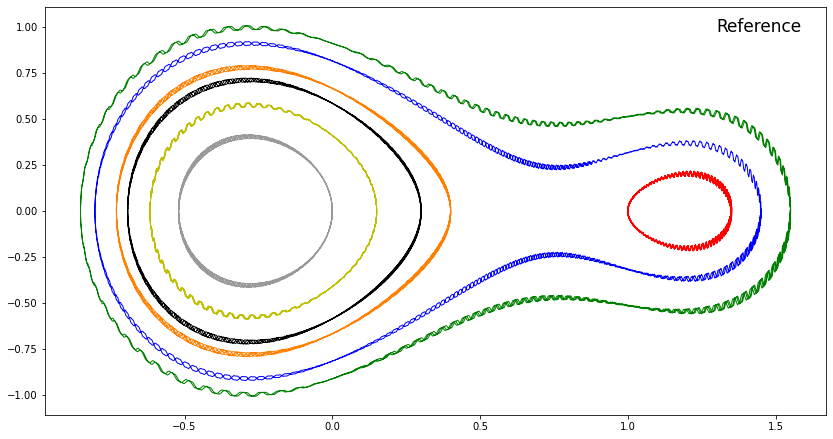

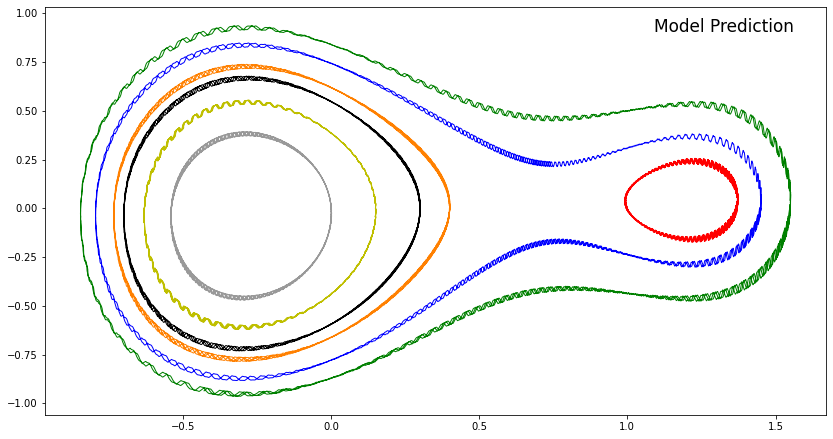

In [18]:
# RK4 Reference Plot for Oscillator 2

fig3, ax3 = plt.subplots(figsize=(14,7.5)) 
    
line3,=ax3.plot(rk_model[4,1,:],rk_model[4,3,:],'r',linewidth = 1)
line3,=ax3.plot(rk_model[3,1,:],rk_model[3,3,:],color =[1, 0.5, 0],linewidth = 1)
line3,=ax3.plot(rk_model[2,1,:],rk_model[2,3,:],'k',linewidth = 1)
line3,=ax3.plot(rk_model[1,1,:],rk_model[1,3,:], 'y' ,linewidth = 1)
line3,=ax3.plot(rk_model[0,1,:],rk_model[0,3,:],color=[0.6, 0.6, 0.6],linewidth = 1)
line3,=ax3.plot(rk_model[5,1,:],rk_model[5,3,:],'b',linewidth = 1)
line3,=ax3.plot(rk_model[6,1,:],rk_model[6,3,:],'g',linewidth = 1)

textstr = "Reference"
ax3.text(0.86,0.94,textstr,transform=ax3.transAxes,fontsize = 17)

Filename = "Reference.png"
plt.savefig(Filename,bbox_inches = 'tight', dpi = 500)


# Symplectic Gyroceptron Plot for Oscillator 2

fig4, ax4 = plt.subplots(figsize=(14,7.5)) 
    
line4,=ax4.plot(NN_model[4,1,:],NN_model[4,3,:],'r',linewidth = 1)
line4,=ax4.plot(NN_model[3,1,:],NN_model[3,3,:],color =[1, 0.5, 0],linewidth = 1)
line4,=ax4.plot(NN_model[2,1,:],NN_model[2,3,:],'k',linewidth = 1)
line4,=ax4.plot(NN_model[1,1,:],NN_model[1,3,:], 'y' ,linewidth = 1)
line4,=ax4.plot(NN_model[0,1,:],NN_model[0,3,:],color=[0.6, 0.6, 0.6],linewidth = 1)
line4,=ax4.plot(NN_model[5,1,:],NN_model[5,3,:],'b',linewidth = 1)
line4,=ax4.plot(NN_model[6,1,:],NN_model[6,3,:],'g',linewidth = 1)
    
textstr = "Model Prediction"
ax4.text(0.78,0.94,textstr,transform=ax4.transAxes,fontsize = 17)

Filename = "Model_Prediction.png"
plt.savefig(Filename,bbox_inches = 'tight', dpi = 500)